In [1]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
dim = 512 
train_dir = f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/train'
weights_dir = '/kaggle/input/v2-10percent-train-as-test-512images/yolov5/runs/train/exp/weights/best.pt'

In [3]:
test_df = pd.read_csv(f'/kaggle/input/train-90-10-split/new_df_10.csv')
test_df.head()

image_id  width  height
0  000ae00eb3942d27e0b97903dd563a6e   3072    3072
1  000ae00eb3942d27e0b97903dd563a6e   3072    3072
2  000ae00eb3942d27e0b97903dd563a6e   3072    3072
3  001d127bad87592efe45a5c7678f8b8d   3072    3072
4  001d127bad87592efe45a5c7678f8b8d   3072    3072

In [4]:
len(test_df)

6675

In [5]:
# dropping ALL duplicte values
test_df.drop_duplicates(subset ="image_id", keep = 'first', inplace = True)

test_df.head()

image_id  width  height
0   000ae00eb3942d27e0b97903dd563a6e   3072    3072
3   001d127bad87592efe45a5c7678f8b8d   3072    3072
9   00291f7aff0123ea76a59998effef229   3072    3072
12  003cfe5ce5c0ec5163138eb3b740e328   1994    2430
15  004dc2a50591fb5f1aaf012bffa95fd9   1994    2430

In [6]:
len(test_df)      # contains findings + no findings

1510

In [7]:
# contains 10% val images
!mkdir val_train_10_images

In [8]:
for image_id in test_df['image_id']:
    shutil.copy('/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train/'+ image_id + '.png', '/kaggle/working/val_train_10_images')


In [9]:
test_dir = '/kaggle/working/val_train_10_images'

# YOLOv5

In [10]:
shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('/kaggle/working/yolov5') # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Inference

In [11]:
!python detect.py --weights $weights_dir\
--img 640\
--conf 0.01\
--iou 0.4\
--source $test_dir\
--save-txt --save-conf --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.01, device='', exist_ok=True, img_size=640, iou_thres=0.4, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/kaggle/working/val_train_10_images', update=False, view_img=False, weights=['/kaggle/input/v2-10percent-train-as-test-512images/yolov5/runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/1510 /kaggle/working/val_train_10_images/000ae00eb3942d27e0b97903dd563a6e.png: 640x640 1 Other lesions, Done. (0.058s)
image 2/1510 /kaggle/working/val_train_10_images/001d127bad87592efe45a5c7678f8b8d.png: 640x640 1 Aortic enlargements, 5 Calcifications, 1 Cardiomegalys, 1 Infiltrations, 2 Lung Opacitys, 5 Nodule/Masss, 2 Other lesions, 1 Pleural effusions, 7 Pleural thickenings, 12 Pulmonary fibrosiss, Done. (0.047s)
image 3/1510 /kaggle/working/val_train_10_images/00291f7aff0123ea76a59998effef229.png: 640x640 1 Pleural effusions, 2 Pleural thickenings, 1 Pulmonary fibrosiss, Done. (0.047s)


# Inference Plot

100%|██████████| 16/16 [00:00<00:00, 104.41it/s]


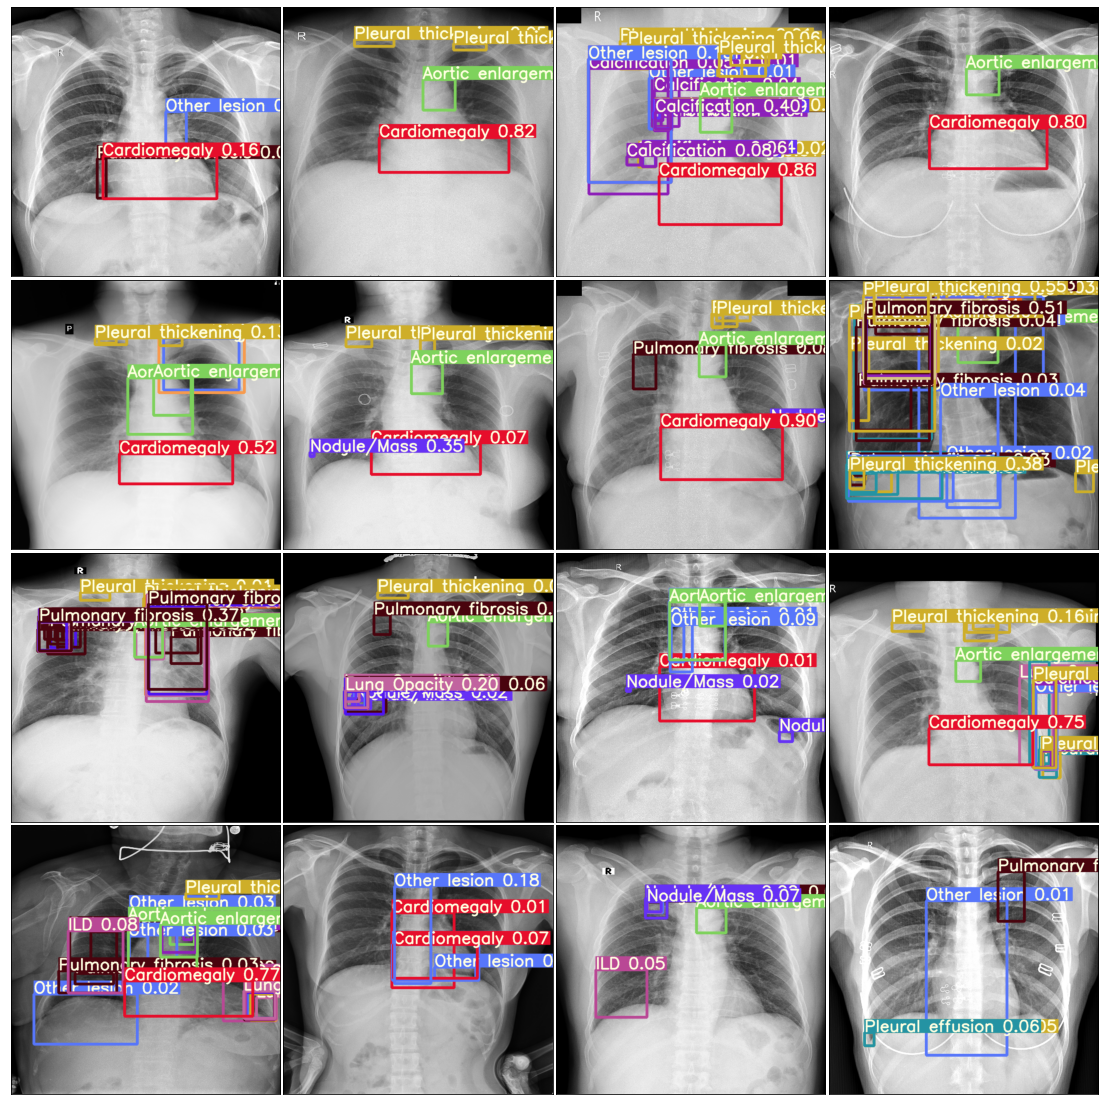

100%|██████████| 16/16 [00:00<00:00, 108.97it/s]


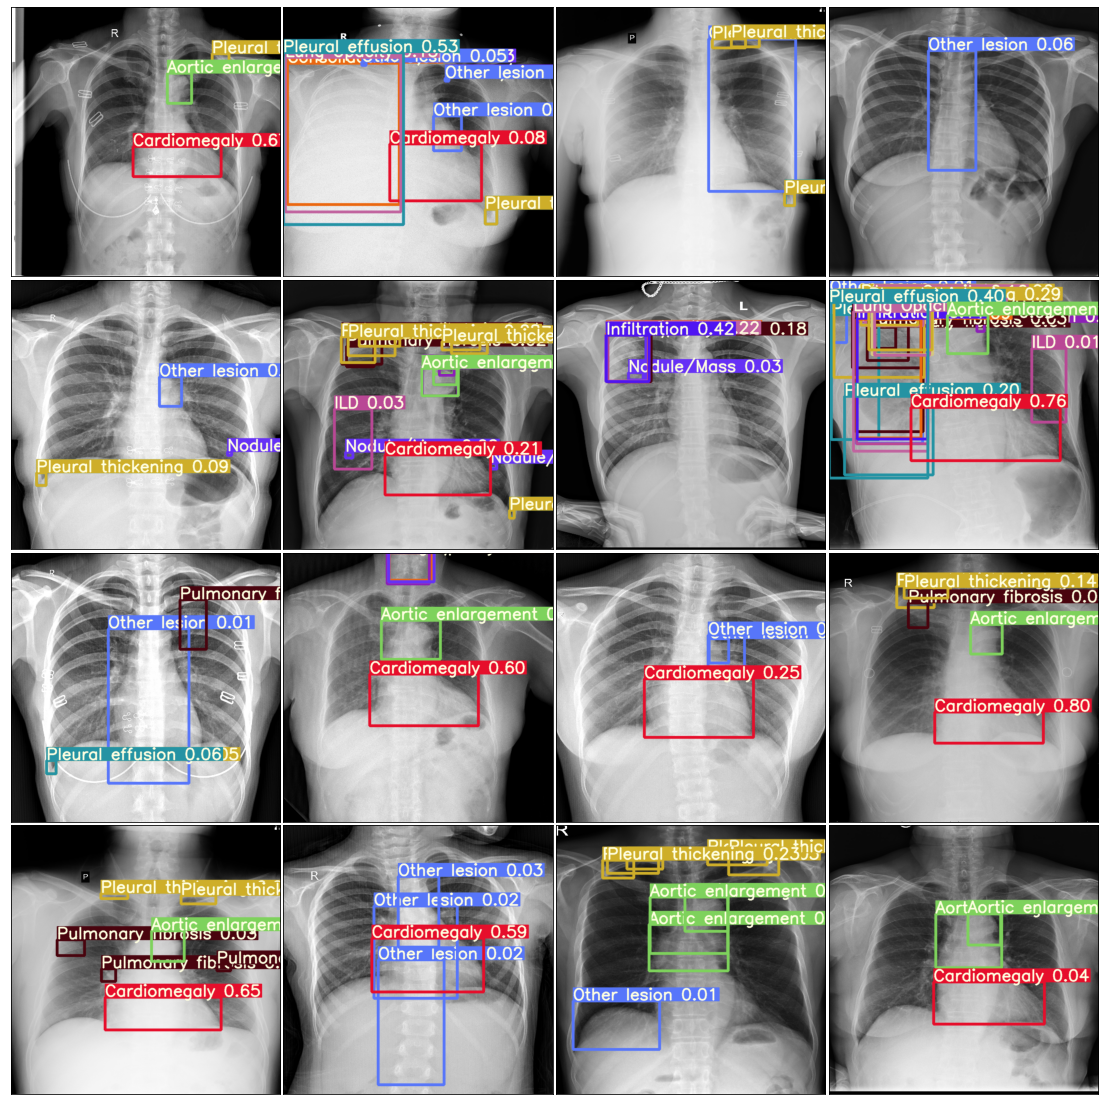

100%|██████████| 16/16 [00:00<00:00, 109.18it/s]


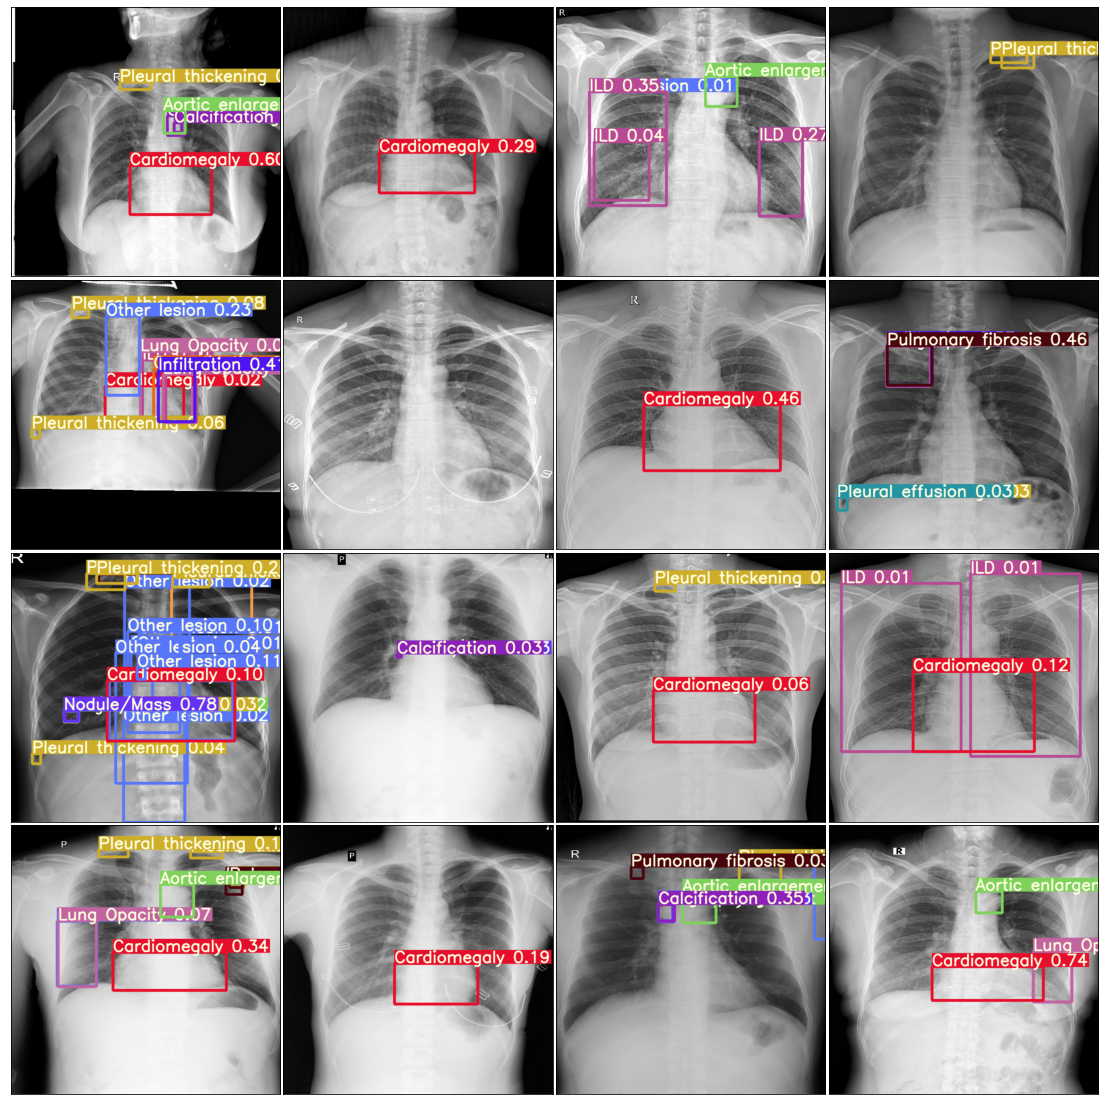

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*png')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Process Submission

In [13]:

def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes


In [14]:
w, h = test_df.loc[test_df.image_id=='000ae00eb3942d27e0b97903dd563a6e',['width', 'height']].values[0]
print(w, h)

3072 3072


In [15]:
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

100%|██████████| 1482/1482 [00:03<00:00, 446.26it/s]


In [16]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv('/kaggle/working/submission.csv',index = False)
sub_df.tail()

image_id  \
1505  ff53fc490ff326e8b66df0f1e9839219   
1506  ff67e54ea3f2d4df695ebfdcb6900a8a   
1507  ff7a03aeaca3523c665c533d9a7e2622   
1508  ff87bf702fb77cbf48bdf732d2f2defa   
1509  ffeffc54594debf3716d6fcd2402a99f   

                                       PredictionString  
1505  11 0.0 1549 332 1924 423 8 0.0 669 1910 736 19...  
1506                            9 0.0 892 479 1236 1475  
1507     11 0.0 585 390 868 588 11 0.0 640 390 1081 504  
1508  11 0.0 109 1780 160 1860 13 0.0 549 361 868 45...  
1509  11 0.0 1396 333 1747 414 13 0.0 19 2852 284 29...

In [17]:
# shutil.rmtree('/kaggle/working/yolov5')

In [18]:
%cd /kaggle/working

from IPython.display import FileLink 
FileLink(r'submission.csv')

/kaggle/working


/kaggle/working/submission.csv